This is a test

In [1]:
import s3fs
import xarray as xr
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
response = requests.get(gesdisc_s3).json() 

fs = s3fs.S3FileSystem(key=response['accessKeyId'],
                    secret=response['secretAccessKey'],
                    token=response['sessionToken'],
                    client_kwargs={'region_name':'us-west-2'})

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs)

s3fs.core.S3FileSystem

In [3]:
# CMR API granule query
host = 'cmr.earthdata.nasa.gov'
url = 'https://'+host+'/search/granules'
headers = {
        'Accept': 'application/json',
        }
params = {
        'provider': 'GES_DISC',
        'short_name': 'TRPSDL2CH4CRS1FS',
        'version': '1',
        'temporal': '2021-04-01T00:00:00Z,2021-04-30T23:59:59Z',
#       'bounding_box': "-80,35,-75,40",
        'page_size': 200,
        }
gran_met = requests.get(url, headers = headers, params = params)

Get the list of all URL links

In [4]:
all_links = [entry['links'] for entry in gran_met.json()['feed']['entry']]

Get just the granule URL links, exclude inherited links (i.e. from collection-level metadata).

In [5]:
gran_links = [link for group in all_links for link in group if 'inherited' not in link.keys()]

Get just the S3 URLs (identified by 'via S3' in the link title)

In [6]:
s3_urls = [link['href'] for link in gran_links if 'via S3' in link['title']]
s3_urls

['s3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210401_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210402_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210403_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210404_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210405_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210406_MUSES_R1p12_FS_F0p1.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH

In [7]:
fn = s3_urls[0]
fs.info(fn)

{'ETag': '"0dc5136d67b4a4753a981fffde1e75dd-1"',
 'LastModified': datetime.datetime(2023, 2, 2, 18, 19, 7, tzinfo=tzutc()),
 'size': 107605990,
 'name': 'gesdisc-cumulus-prod-protected/TROPESS_Standard/TRPSDL2CH4CRS1FS.1/2021/TROPESS_CrIS-JPSS1_L2_Standard_CH4_20210401_MUSES_R1p12_FS_F0p1.nc',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'application/x-netcdf'}

In [8]:
xds = xr.open_dataset(fs.open(fn),) # decode_cf=True,)
xds

<xarray.Dataset>
Dimensions:        (target: 23710, datetime_utc_dim: 6, level: 26)
Coordinates:
    longitude      (target) float32 ...
    latitude       (target) float32 ...
Dimensions without coordinates: target, datetime_utc_dim, level
Data variables:
    time           (target) datetime64[ns] ...
    datetime_utc   (target, datetime_utc_dim) float64 ...
    year_fraction  (target) float64 ...
    altitude       (target, level) float32 ...
    pressure       (target, level) float32 ...
    x              (target, level) float32 ...
Attributes: (12/23)
    ShortName:                      TRPSDL2CH4CRS1FS
    LongName:                       TROPESS CrIS-JPSS1 L2 Methane for Forward...
    VersionID:                      1
    IdentifierProductDOIAuthority:  https://doi.org/
    IdentifierProductDOI:           10.5067/QOFZLQYMGA72
    Format:                         NetCDF-4
    ...                             ...
    source:                         MUSES v1.12
    history:                        20210727T224311Z: original file created a...
    Conventions:                    CF-1.8
    MeasuredParameter:              CH4
    Platform:                       JPSS-1
    Instrument:                     CrIS

In [9]:
x = (xds['latitude'].values  >   24) & (xds['latitude'].values  <   50) & \
    (xds['longitude'].values > -125) & (xds['longitude'].values <  -65)

lat = xds['latitude'].values[x]
lon = xds['longitude'].values[x]
dat = xds['x'].values[x]
t = xds['time'].values[x]
p = xds['pressure'].values[x]

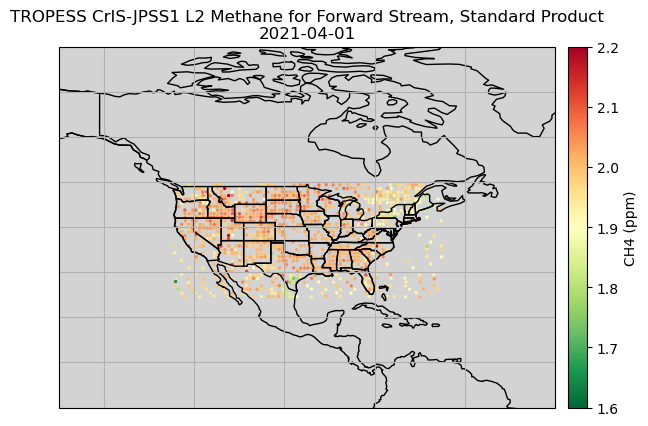

In [10]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_facecolor('lightgrey')
#ax.set_global()
ax.set_extent([-150, -40, 0, 80], ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.gridlines()

psc = plt.scatter(lon, lat, c=dat[:,6]/1e-06,
                  transform=ccrs.PlateCarree(),
                  norm=mpl.colors.Normalize(vmin=1.6, vmax=2.2),
                  cmap=mpl.colormaps['RdYlGn_r'],
                  s=2,)

plt.title(xds.attrs['LongName']+'\n'+xds.attrs['RangeBeginningDate'])

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(psc, label=xds.attrs['MeasuredParameter']+' (ppm)',cax=cax)


plt.show()

In [11]:
t=xds['time'].values[x]
t

array(['2021-04-01T05:45:36.000000000', '2021-04-01T05:45:36.000000000',
       '2021-04-01T05:46:40.000000000', ...,
       '2021-04-01T20:36:16.000000000', '2021-04-01T20:36:16.000000000',
       '2021-04-01T20:36:16.000000000'], dtype='datetime64[ns]')

In [15]:
xdg = xr.open_dataset(fs.open(fn),group='geophysical') # decode_cf=True,)
xdg

<xarray.Dataset>
Dimensions:              (target: 23710)
Dimensions without coordinates: target
Data variables:
    land_flag            (target) float64 ...
    day_night_flag       (target) float64 ...
    surface_temperature  (target) float32 ...
    average_cloud_eod    (target) float32 ...
    cloud_top_pressure   (target) float32 ...
Attributes:
    comment:  geophysical attributes

In [16]:
! df -h

Filesystem                                              Size  Used Avail Use% Mounted on
overlay                                                  80G  9.7G   71G  13% /
tmpfs                                                    64M     0   64M   0% /dev
tmpfs                                                    16G     0   16G   0% /sys/fs/cgroup
fs-b25253b5.efs.us-west-2.amazonaws.com:/prod/jejohns1  8.0E  1.4T  8.0E   1% /home/jovyan
/dev/nvme0n1p1                                           80G  9.7G   71G  13% /etc/hosts
shm                                                      64M     0   64M   0% /dev/shm
fs-b25253b5.efs.us-west-2.amazonaws.com:/prod/_shared   8.0E  1.4T  8.0E   1% /home/jovyan/shared
tmpfs                                                    30G  4.0K   30G   1% /run/secrets/eks.amazonaws.com/serviceaccount
tmpfs                                                    30G   12K   30G   1% /usr/local/etc/ipython/ipython_kernel_config.json
tmpfs                                 